In [1]:
# pip install ucimlrepo
# pip install skorch
from ucimlrepo import fetch_ucirepo 

# https://archive.ics.uci.edu/dataset/222/bank+marketing

# fetch dataset 
bank_marketing = fetch_ucirepo(id=222) 

# data (as pandas dataframes) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 

In [2]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F 
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score,f1_score,ConfusionMatrixDisplay,confusion_matrix,accuracy_score,classification_report
from sklearn.svm import SVC

In [16]:
import seaborn as sns

<AxesSubplot:ylabel='count'>

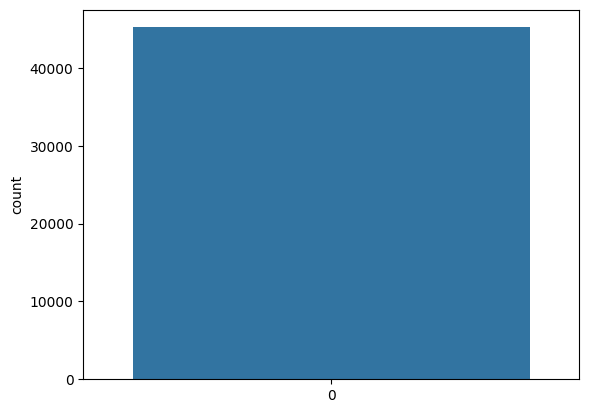

In [17]:
sns.countplot(y)

In [18]:
y.value_counts(normalize=True)

0    0.883015
1    0.116985
Name: y, dtype: float64

([<matplotlib.axis.XTick at 0x1a382214130>,
 [Text(0, 0, 'no'), Text(1, 0, 'yes')])

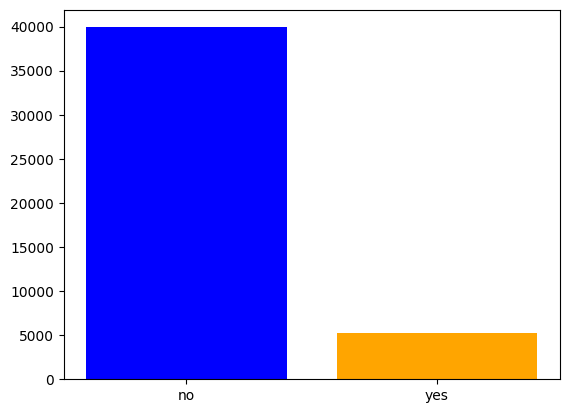

In [25]:
# Sample target data (replace this with your actual target column data)
target = y

# Count the occurrences of each class
unique_classes, class_counts = np.unique(target, return_counts=True)

# Create the bar plot
plt.bar(unique_classes, class_counts, color=['blue', 'orange'])
plt.xticks(unique_classes, ['no', 'yes'])

In [4]:
y = y['y'].replace(['yes','no'],[1,0])

In [5]:
X.isna().mean()*100

age             0.000000
job             0.637013
marital         0.000000
education       4.107407
default         0.000000
balance         0.000000
housing         0.000000
loan            0.000000
contact        28.798301
day_of_week     0.000000
month           0.000000
duration        0.000000
campaign        0.000000
pdays           0.000000
previous        0.000000
poutcome       81.747805
dtype: float64

In [6]:
X.drop('poutcome',axis=1,inplace=True)

C:\Users\avitr\AppData\Local\Temp\ipykernel_2352\2877319344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop('poutcome',axis=1,inplace=True)


In [7]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [9]:
# Columns to apply StandardScaler and OneHotEncoder
categorical_cols = list(set(X.select_dtypes('O')))
numeric_cols = list(set(X) - set(X.select_dtypes('O')))

# Define preprocessing steps for numeric and categorical columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values
    ('scaler', StandardScaler())  # Standard scaling
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encoding
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing to the entire dataset
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [10]:
up_sample = SMOTE(random_state=42)
down_sample = RandomUnderSampler(random_state=42)

X_train_up, y_train_up = up_sample.fit_resample(X_train,y_train)
X_train_down, y_train_down = down_sample.fit_resample(X_train,y_train)

In [11]:
def exp_svc(k):
    for train_x,train_y in [(X_train,y_train),(X_train_up,y_train_up), (X_train_down,y_train_down)]:
        svc_clf = SVC(kernel=k)
        svc_clf.fit(train_x,train_y)
        pred_svc = svc_clf.predict(X_test)
        cm = confusion_matrix(y_test, pred_svc, labels=svc_clf.classes_)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['no','yes'])
        disp.plot(values_format=".2f")
        plt.show()
        print(classification_report(y_test,pred_svc))

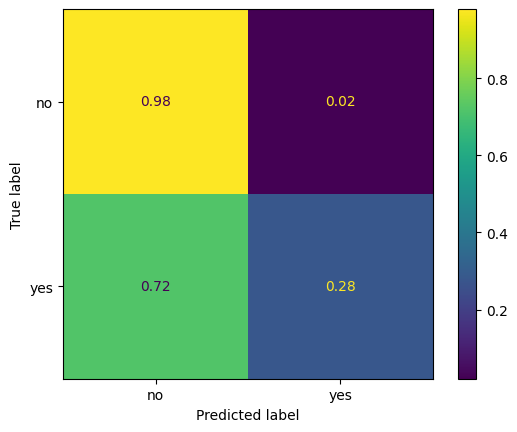

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     13175
           1       0.64      0.28      0.39      1745

    accuracy                           0.90     14920
   macro avg       0.78      0.63      0.67     14920
weighted avg       0.88      0.90      0.88     14920



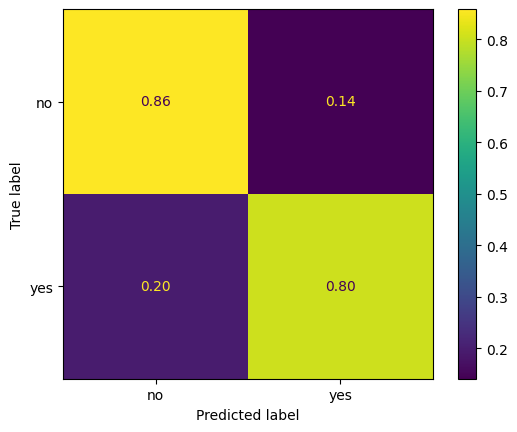

              precision    recall  f1-score   support

           0       0.97      0.86      0.91     13175
           1       0.43      0.80      0.56      1745

    accuracy                           0.85     14920
   macro avg       0.70      0.83      0.74     14920
weighted avg       0.91      0.85      0.87     14920



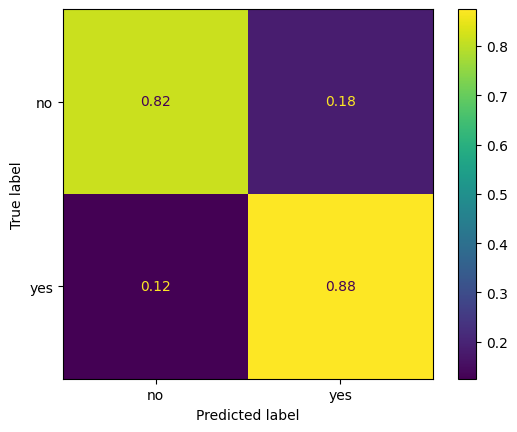

              precision    recall  f1-score   support

           0       0.98      0.82      0.89     13175
           1       0.39      0.88      0.54      1745

    accuracy                           0.82     14920
   macro avg       0.68      0.85      0.71     14920
weighted avg       0.91      0.82      0.85     14920



In [12]:
exp_svc('rbf')

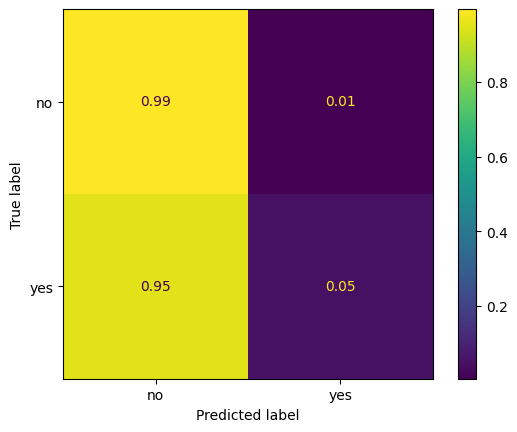

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     13175
           1       0.54      0.05      0.09      1745

    accuracy                           0.88     14920
   macro avg       0.71      0.52      0.51     14920
weighted avg       0.85      0.88      0.84     14920



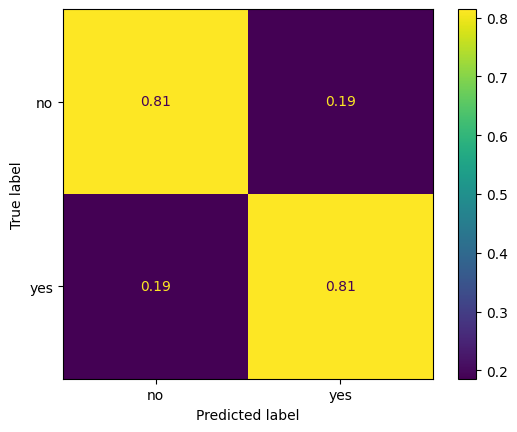

              precision    recall  f1-score   support

           0       0.97      0.81      0.89     13175
           1       0.37      0.81      0.51      1745

    accuracy                           0.81     14920
   macro avg       0.67      0.81      0.70     14920
weighted avg       0.90      0.81      0.84     14920



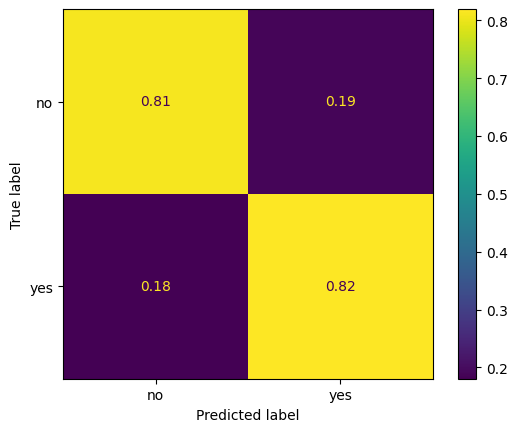

              precision    recall  f1-score   support

           0       0.97      0.81      0.88     13175
           1       0.36      0.82      0.50      1745

    accuracy                           0.81     14920
   macro avg       0.67      0.81      0.69     14920
weighted avg       0.90      0.81      0.84     14920



In [13]:
exp_svc('linear')

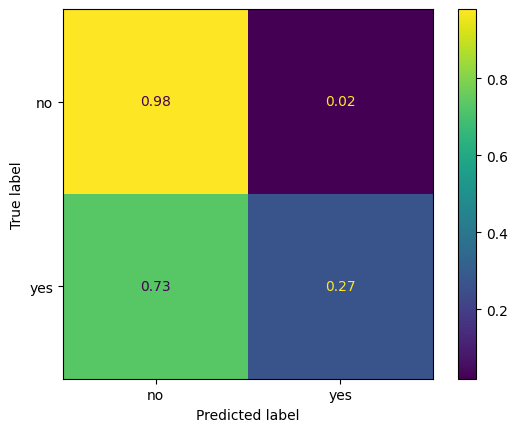

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     13175
           1       0.64      0.27      0.38      1745

    accuracy                           0.90     14920
   macro avg       0.77      0.62      0.66     14920
weighted avg       0.88      0.90      0.88     14920



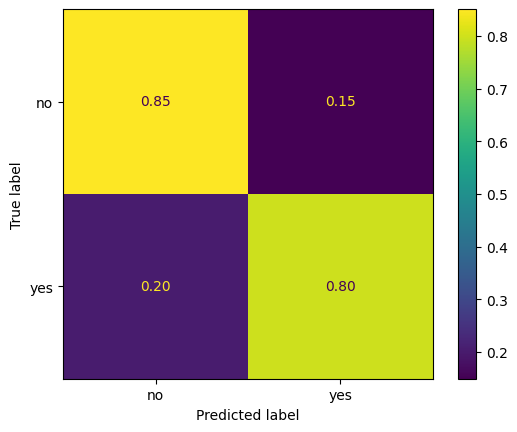

              precision    recall  f1-score   support

           0       0.97      0.85      0.91     13175
           1       0.41      0.80      0.55      1745

    accuracy                           0.84     14920
   macro avg       0.69      0.82      0.73     14920
weighted avg       0.90      0.84      0.86     14920



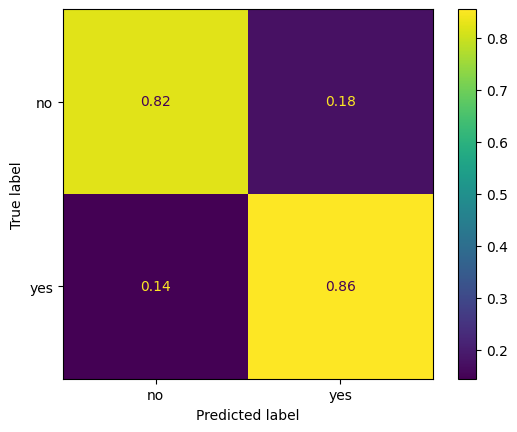

              precision    recall  f1-score   support

           0       0.98      0.82      0.89     13175
           1       0.39      0.86      0.54      1745

    accuracy                           0.83     14920
   macro avg       0.68      0.84      0.72     14920
weighted avg       0.91      0.83      0.85     14920



In [14]:
exp_svc('poly')

In [15]:
stop

NameError: name 'stop' is not defined

# MLP

In [ ]:
X_train_t = torch.tensor(X_train)
y_train_t = torch.tensor(y_train.values)
X_train_t = X_train_t.to(dtype=torch.float32) 
y_train_t = y_train_t.to(torch.int64) 


X_train_up = torch.tensor(X_train_up)
y_train_up = torch.tensor(y_train_up.values)
X_train_up = X_train_up.to(dtype=torch.float32) 
y_train_up = y_train_up.to(torch.int64) 


X_train_down = torch.tensor(X_train_down)
y_train_down = torch.tensor(y_train_down.values)
X_train_down = X_train_down.to(dtype=torch.float32) 
y_train_down = y_train_down.to(torch.int64) 

X_test_t = torch.tensor(X_test)
y_test_t = torch.tensor(y_test.values)
X_test_t = X_test_t.to(dtype=torch.float32) 
y_test_t = y_test_t.to(torch.int64) 

In [ ]:
# Define your PyTorch model
class StockClassifier(nn.Module):
    def __init__(self, input_dim,num_classes,dropout=0.5):
        super(StockClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        X = self.dropout(x)
        x = self.fc3(x)
        return x

# Create an instance of your custom neural network
mymodel = StockClassifier(44,2)

# Wrap your PyTorch model with Skorch
net = NeuralNetClassifier(
    module=mymodel,
    module__input_dim=X_train.shape[1],  # Input dimension
    module__num_classes=2,  # Number of output classes
    criterion=nn.CrossEntropyLoss,  # Loss function
    optimizer=optim.Adam,  # Optimizer Adam
    optimizer__lr=0.001,  # Learning rate
    optimizer__weight_decay=1e-4,  # L2 regularization
    max_epochs=100,  # Maximum number of training epochs
    batch_size=32,  # Batch size for training
    iterator_train__shuffle=True,  # Shuffle training data
    callbacks=[EarlyStopping(patience=3)],  # Early stopping callback
    device='cuda' if torch.cuda.is_available() else 'cpu'  # Device (GPU if available, else CPU)
)

# Train the model
net.fit(X_train_t, y_train_t)

In [ ]:
from skorch import NeuralNetClassifier
import torch.nn as nn
import torch.optim as optim
from skorch.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

In [ ]:
# Create an instance of the neural network classifier
net = NeuralNetClassifier(
    module=mymodel,
#     optimizer__momentum=0.95,
    module__input_dim=X_train.shape[1],  # Input dimension
    module__num_classes=2,  # Number of output classes
    criterion=nn.CrossEntropyLoss,  # Loss function
    optimizer=optim.Adam,  # Optimizer Adam
    optimizer__lr=0.001,  # Learning rate
    optimizer__weight_decay=1e-5,  # L2 regularization
    max_epochs=100,  # Maximum number of training epochs
    batch_size=32,  # Batch size for training
    iterator_train__shuffle=True,  # Shuffle training data
    callbacks=[EarlyStopping(patience=3)],  # Early stopping callback
    device='cuda' if torch.cuda.is_available() else 'cpu'  # Device (GPU if available, else CPU)
)

# Define hyperparameters to tune
params = {
#     'optimizer__lr': [1e-5, 1e-4, 1e-3],
#     'optimizer__momentum': [0.9,0.95 ,0.99],
    'optimizer__weight_decay': [1e-4, 1e-5],
}

# Perform grid search with cross-validation
gs = GridSearchCV(net, params, cv=3, scoring='accuracy', verbose=2)
gs.fit(X_train_up, y_train_up)

# Print best parameters and score
print("Best parameters:", gs.best_params_)
print("Best score:", gs.best_score_)

In [ ]:
# Evaluate the model
accuracy = net.score(X_test_t, y_test_t)
print(f"Test Accuracy: {accuracy}")

pred = net.predict(X_test_t)
print(classification_report(y_test,pred))

In [ ]:
net.fit(X_train_up, y_train_up)

In [ ]:
# Evaluate the model
accuracy = net.score(X_test_t, y_test_t)
print(f"Test Accuracy: {accuracy}")

pred = net.predict(X_test_t)
print(classification_report(y_test,pred))

In [ ]:
# Train the model
net.fit(X_train_down, y_train_down)

In [ ]:
# Evaluate the model
accuracy = net.score(X_test_t, y_test_t)
print(f"Test Accuracy: {accuracy}")

pred = net.predict(X_test_t)
print(classification_report(y_test,pred))

In [26]:
net = NeuralNetClassifier()

TypeError: NeuralNetClassifier.__init__() missing 1 required positional argument: 'module'